In [5]:
import cv2
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
# sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')

# This is needed to display the images.
%matplotlib inline

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [6]:
# ------------------ spider Model Initialization ------------------------------ #
spider_label_map = label_map_util.load_labelmap('/Users/mac/Desktop/models/research/object_detection/correctmodel/labelmap.pbtxt')
spider_categories = label_map_util.convert_label_map_to_categories(
    spider_label_map, max_num_classes=11, use_display_name=True)
spider_category_index = label_map_util.create_category_index(spider_categories)

spider_detection_graph = tf.Graph()

with spider_detection_graph.as_default():
    spider_od_graph_def = tf.GraphDef()
    with tf.gfile.GFile('/Users/mac/Desktop/models/research/object_detection/correctmodel/train2/out/frozen_inference_graph.pb', 'rb') as fid:
        spider_serialized_graph = fid.read()
        spider_od_graph_def.ParseFromString(spider_serialized_graph)
        tf.import_graph_def(spider_od_graph_def, name='')

    spider_session = tf.Session(graph=spider_detection_graph)

spider_image_tensor = spider_detection_graph.get_tensor_by_name(
    'image_tensor:0')
spider_detection_boxes = spider_detection_graph.get_tensor_by_name(
    'detection_boxes:0')
spider_detection_scores = spider_detection_graph.get_tensor_by_name(
    'detection_scores:0')
spider_detection_classes = spider_detection_graph.get_tensor_by_name(
    'detection_classes:0')
spider_num_detections = spider_detection_graph.get_tensor_by_name(
    'num_detections:0')
# ---------------------------------------------------------------------------- #

In [8]:
# ------------------ General Model Initialization ---------------------------- #
# What model to download.
MODEL_NAME = 'faster_rcnn_inception_v2_coco_2018_01_28'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = '/Users/mac/Downloads/' + MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/Users/mac/Desktop/models/research/object_detection/data/mscoco_label_map.pbtxt'
general_label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
general_categories = label_map_util.convert_label_map_to_categories(
    general_label_map, max_num_classes=90, use_display_name=True)
general_category_index = label_map_util.create_category_index(
    general_categories)

general_detection_graph = tf.Graph()

with general_detection_graph.as_default():
    general_od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        general_serialized_graph = fid.read()
        general_od_graph_def.ParseFromString(general_serialized_graph)
        tf.import_graph_def(general_od_graph_def, name='')

    general_session = tf.Session(graph=general_detection_graph)

general_image_tensor = general_detection_graph.get_tensor_by_name(
    'image_tensor:0')
general_detection_boxes = general_detection_graph.get_tensor_by_name(
    'detection_boxes:0')
general_detection_scores = general_detection_graph.get_tensor_by_name(
    'detection_scores:0')
general_detection_classes = general_detection_graph.get_tensor_by_name(
    'detection_classes:0')
general_num_detections = general_detection_graph.get_tensor_by_name(
    'num_detections:0')
# ---------------------------------------------------------------------------- #

In [9]:
def spider(image_path):
    try:
        image = cv2.imread(image_path)
        image_expanded = np.expand_dims(image, axis=0)
        (boxes, scores, classes, num) = spider_session.run(
            [spider_detection_boxes, spider_detection_scores,
                spider_detection_classes, spider_num_detections],
            feed_dict={spider_image_tensor: image_expanded})

        classes = np.squeeze(classes).astype(np.int32)
        scores = np.squeeze(scores)
        boxes = np.squeeze(boxes)
        
        object_name = []
        object_score = []

        for c in range(0, len(classes)):
            class_name = spider_category_index[classes[c]]['name']
            if scores[c] > .80:
                object_name.append(class_name)
                object_score.append(str(scores[c] * 100)[:5])
    except:
        print("Error occurred in spider detection")
        object_name = ['']
        object_score = ['']
    return object_name, object_score

In [10]:
def general(image_path):
    try:
        image = cv2.imread(image_path)
        image_expanded = np.expand_dims(image, axis=0)
        (boxes, scores, classes, num) = general_session.run(
            [general_detection_boxes, general_detection_scores,
                general_detection_classes, general_num_detections],
            feed_dict={general_image_tensor: image_expanded})

        classes = np.squeeze(classes).astype(np.int32)
        scores = np.squeeze(scores)
        boxes = np.squeeze(boxes)

        object_name = []
        object_score = []

        for c in range(0, len(classes)):
            class_name = general_category_index[classes[c]]['name']
            if scores[c] > .30:   # If confidence level is good enough
                object_name.append(class_name)
                object_score.append(str(scores[c] * 100)[:5])
    except:
        print("Error occurred in general detection")
        object_name = ['']
        object_score = ['']

    return object_name, object_score

In [11]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [12]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: image})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [13]:
IMAGE_SIZE = (12, 8)
def print_label(image_path,detection_graph, category_index):
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=5)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.show()

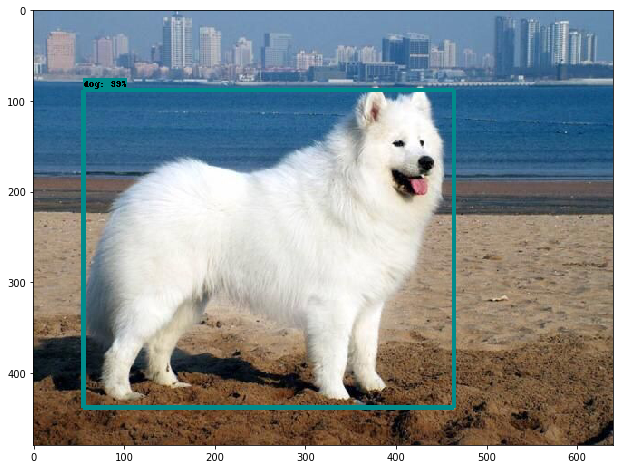

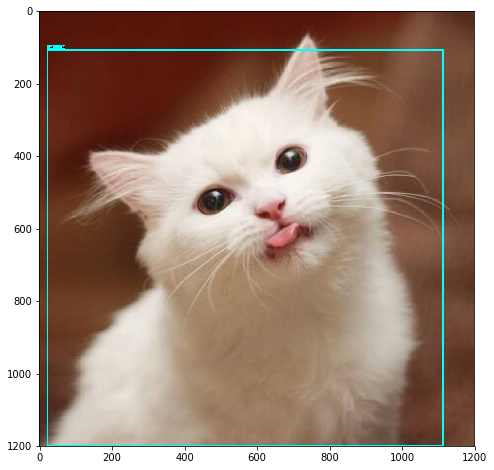

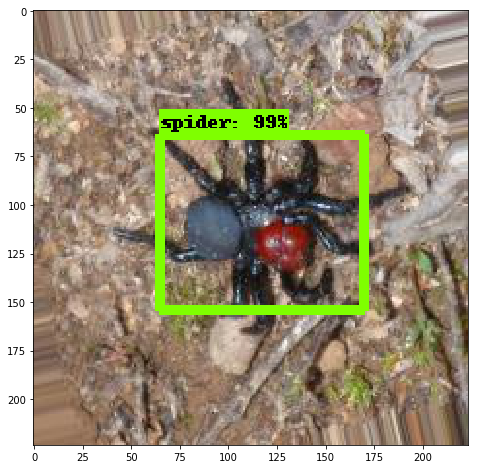

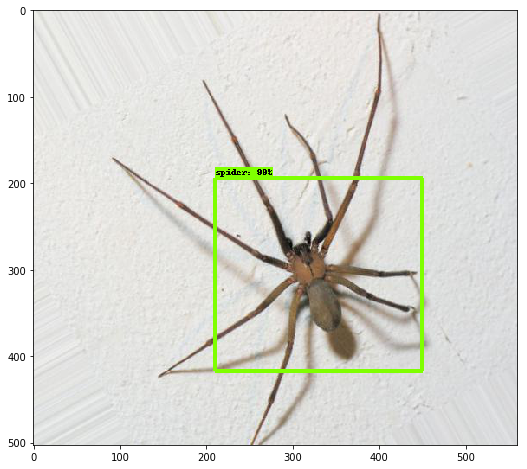

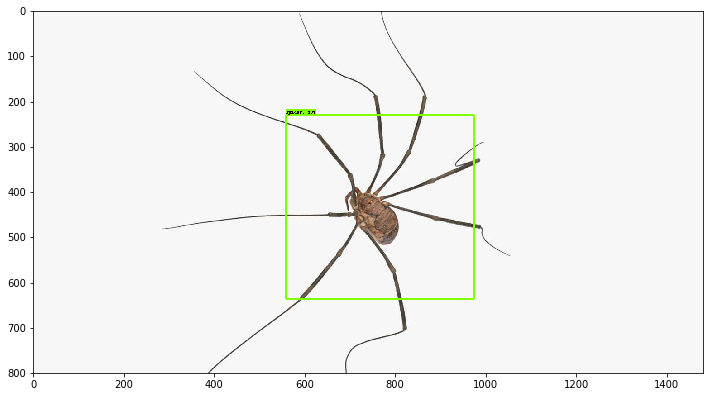

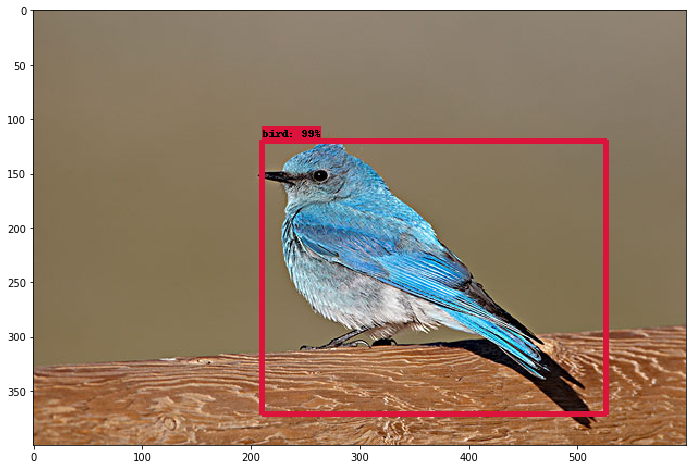

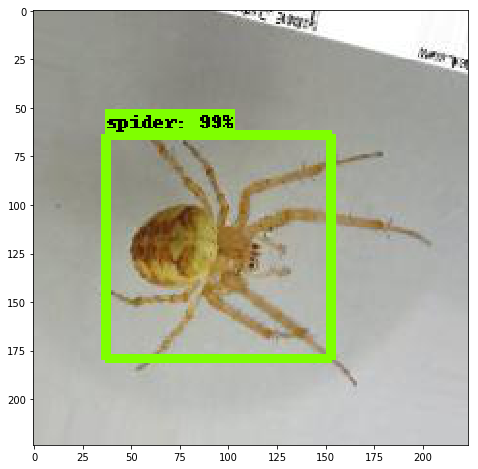

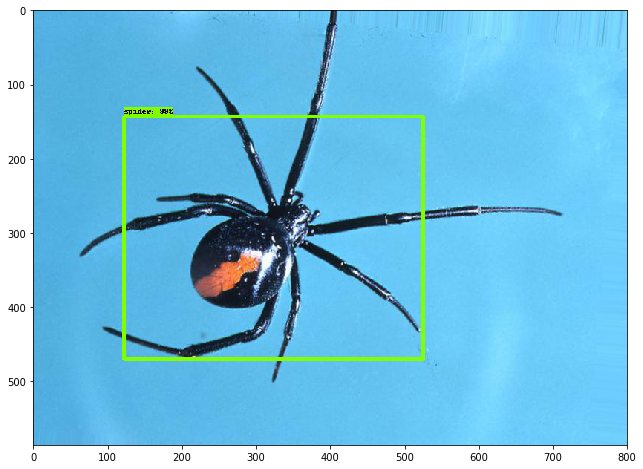

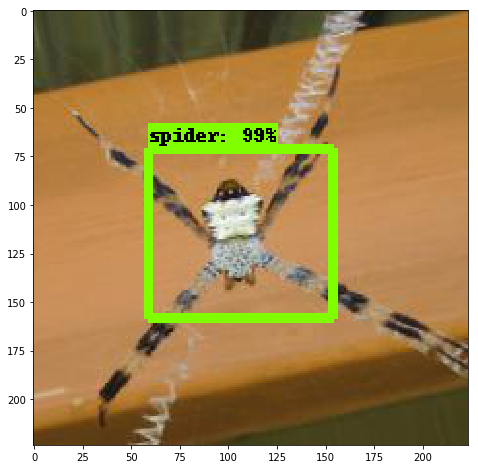

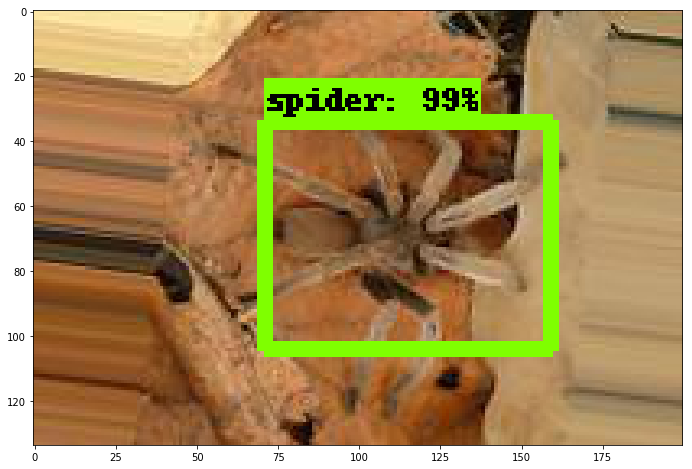

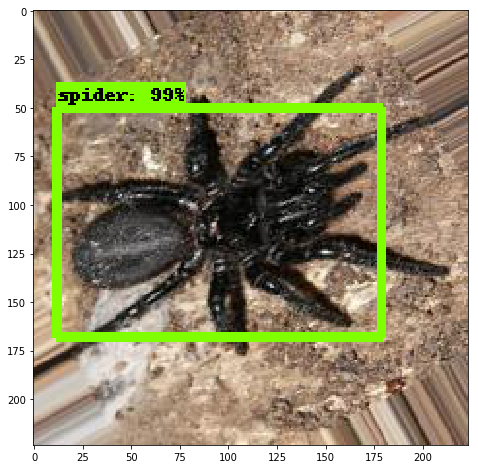

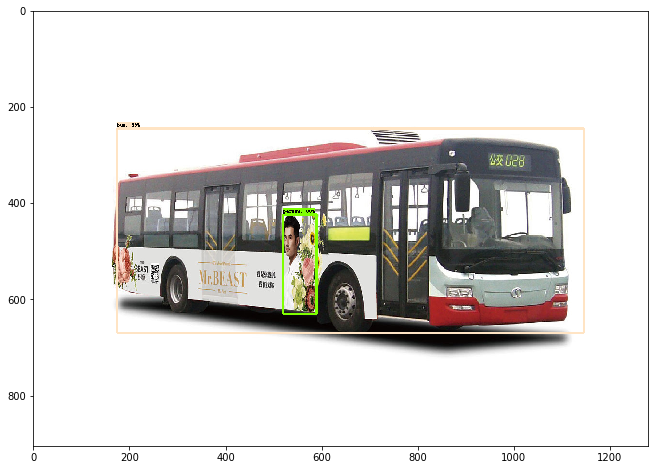

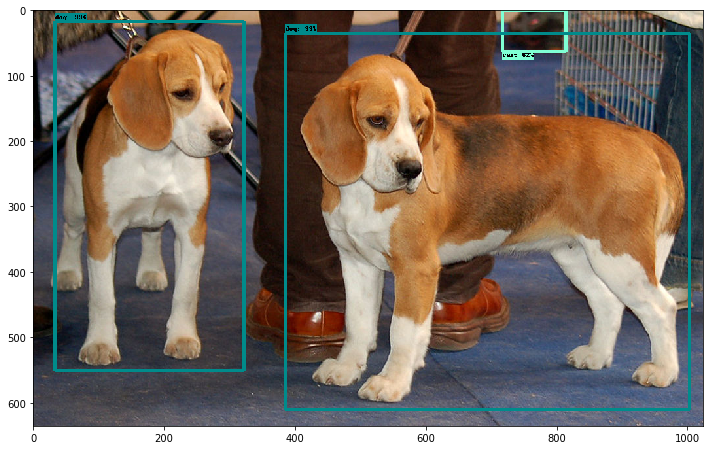

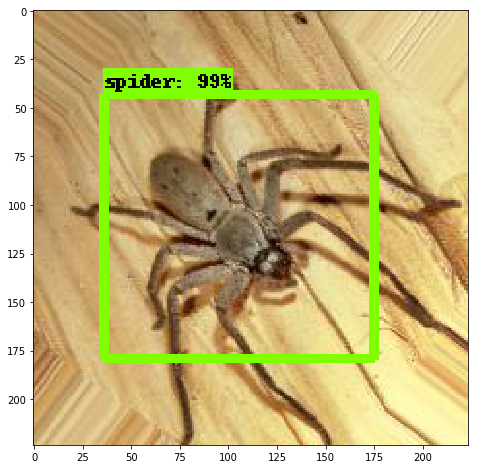

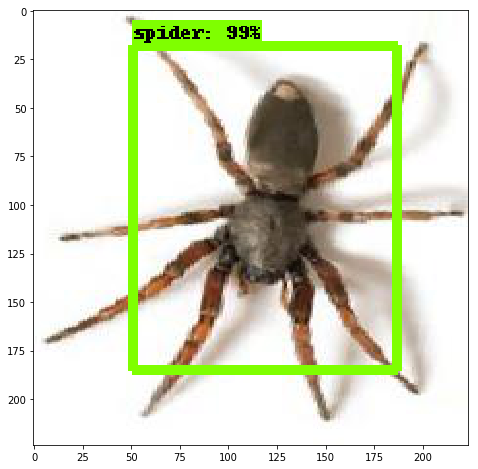

In [14]:
PATH_TO_TEST_IMAGES_DIR = '/Users/mac/Desktop/spider/testimgs/'

TEST_IMAGE_PATHS = []
for x in os.listdir(PATH_TO_TEST_IMAGES_DIR):
    if x == '.DS_Store':
        continue
    else:
        TEST_IMAGE_PATHS.append(PATH_TO_TEST_IMAGES_DIR+x)
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

for image_path in TEST_IMAGE_PATHS:
    sname, sscores = spider(image_path)  # to detect whether spider is present in image(this is custom trained model)
    gname, gscores = general(image_path)  # to detect those 90 objects from TF API
    if len(gname)==0 and len(sname)>0:
        print_label(image_path, spider_detection_graph, spider_category_index)
    elif len(sname)==0 and len(gname)>0:
        print_label(image_path, general_detection_graph, general_category_index)
    elif len(sname)==0 and len(gname)==0:
        print('cannot detect')
    else:
        if float(max(sscores)) - 1 > float(max(gscores)):
            print_label(image_path, spider_detection_graph, spider_category_index)
        else:
            print_label(image_path, general_detection_graph, general_category_index) 
   

In [31]:
gscores

['99.90', '58.97', '42.81']

In [32]:
sscores

[]

In [18]:
general_category_index

{1: {'id': 1, 'name': u'person'},
 2: {'id': 2, 'name': u'bicycle'},
 3: {'id': 3, 'name': u'car'},
 4: {'id': 4, 'name': u'motorcycle'},
 5: {'id': 5, 'name': u'airplane'},
 6: {'id': 6, 'name': u'bus'},
 7: {'id': 7, 'name': u'train'},
 8: {'id': 8, 'name': u'truck'},
 9: {'id': 9, 'name': u'boat'},
 10: {'id': 10, 'name': u'traffic light'},
 11: {'id': 11, 'name': u'fire hydrant'},
 13: {'id': 13, 'name': u'stop sign'},
 14: {'id': 14, 'name': u'parking meter'},
 15: {'id': 15, 'name': u'bench'},
 16: {'id': 16, 'name': u'bird'},
 17: {'id': 17, 'name': u'cat'},
 18: {'id': 18, 'name': u'dog'},
 19: {'id': 19, 'name': u'horse'},
 20: {'id': 20, 'name': u'sheep'},
 21: {'id': 21, 'name': u'cow'},
 22: {'id': 22, 'name': u'elephant'},
 23: {'id': 23, 'name': u'bear'},
 24: {'id': 24, 'name': u'zebra'},
 25: {'id': 25, 'name': u'giraffe'},
 27: {'id': 27, 'name': u'backpack'},
 28: {'id': 28, 'name': u'umbrella'},
 31: {'id': 31, 'name': u'handbag'},
 32: {'id': 32, 'name': u'tie'},
 3